In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [2]:
# # Load the dataset
# X, Y, info = mypackage.Dataset.load("data/tomra", only_with_contaminant=True)
# X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

# X_test, X_train, scaler = mypackage.Dataset.scale(X_test, X_train, scaler='GlobalStandardization')
# # X_test, X_train = mypackage.Dataset.PCA(X_test, X_train, n_components=3, plot=True)

# print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape)

In [3]:
wavelengths = mypackage.Dataset.TOMRA_WAVELENGTHS

# The fake dataset is by default a absorbance dataset
fake_data = mypackage.FakeDataset(wavelengths=wavelengths)
X, Y = fake_data.get_images(30)

X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)
X_test, X_train, scaler = mypackage.Dataset.scale(X_test, X_train, scaler='GlobalStandardization')
X_test, X_train = mypackage.Dataset.PCA(X_test, X_train, n_components=30, plot=False)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape)

[1 2] (9, 64, 64, 1) (-19.46355652549752, 134.46012850648813) (9, 64, 64, 30)


# Test the HybridSN

In [4]:
n_train = 16
n_test  = 4
model = mypackage.HybridSN(X_train[:n_train], Y_train[:n_train], X_test[:n_test], Y_test[:n_test])
model.summary()

count, n, m, k = (16, 64, 64, 30)
X.shape = (256, 256, 30)
X.shape = (256, 256, 30), Y.shape = (256, 256, 1)
count, n, m, k = (4, 64, 64, 30)
X.shape = (128, 128, 30)
X.shape = (128, 128, 30), Y.shape = (128, 128, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 30, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 18, 32)    13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 576)       0         
________________________________________

In [5]:
model.train(epochs=4)

Epoch 1/4
66/66 [==============================] - 1952s 30s/step - loss: 0.0760 - accuracy: 0.9710 - val_loss: 0.0378 - val_accuracy: 0.9884

Epoch 00001: accuracy improved from -inf to 0.97100, saving model to HybridSN-best-model.hdf5
Epoch 2/4
66/66 [==============================] - 1948s 30s/step - loss: 0.0138 - accuracy: 0.9945 - val_loss: 0.0366 - val_accuracy: 0.9882

Epoch 00002: accuracy improved from 0.97100 to 0.99445, saving model to HybridSN-best-model.hdf5
Epoch 3/4
66/66 [==============================] - 1949s 30s/step - loss: 0.0114 - accuracy: 0.9957 - val_loss: 0.0487 - val_accuracy: 0.9894

Epoch 00003: accuracy improved from 0.99445 to 0.99574, saving model to HybridSN-best-model.hdf5
Epoch 4/4
66/66 [==============================] - 1952s 30s/step - loss: 0.0093 - accuracy: 0.9963 - val_loss: 0.0509 - val_accuracy: 0.9911

Epoch 00004: accuracy improved from 0.99574 to 0.99629, saving model to HybridSN-best-model.hdf5


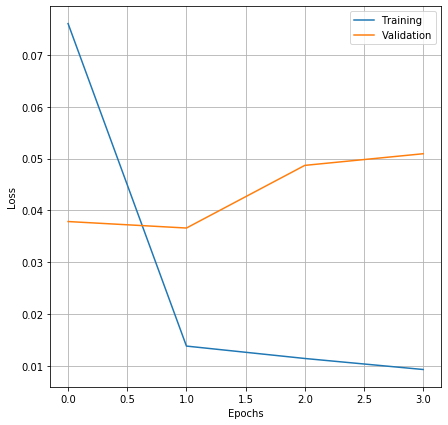

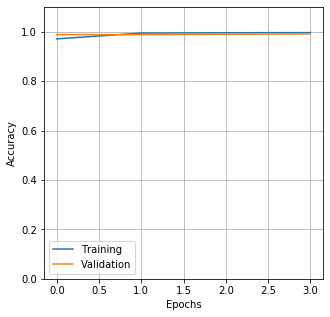

In [6]:
model.plot_training_results()

In [43]:
_, n, m, k = X_test[:1].shape

margin = int((model.windowSize - 1) / 2)
selectable_pixels = model._HybridSN__get_selectable_pixels(n, m, margin)
y_pred_test = np.zeros((n, m))
# TODO: For each (r, c) do the prediction and collect the predictions to a reconstructed image
# _, x, y, _ = np.where(Y_test[:1] == 1)
# selectable_pixels = zip(x, y)
for r, c in selectable_pixels:
    patch = X_test[:1][:1, r - margin:marginr + margin + 1, c - margin:c + margin + 1]

    patch = patch.reshape(*(patch.shape), 1)
    prediction = model.model.predict(patch)
    y_pred_test[r - margin, c - margin] = np.argmax(prediction, axis=-1)

In [42]:
y_pred_test_NoChange = y_pred_test.copy()

<IPython.core.display.Javascript object>


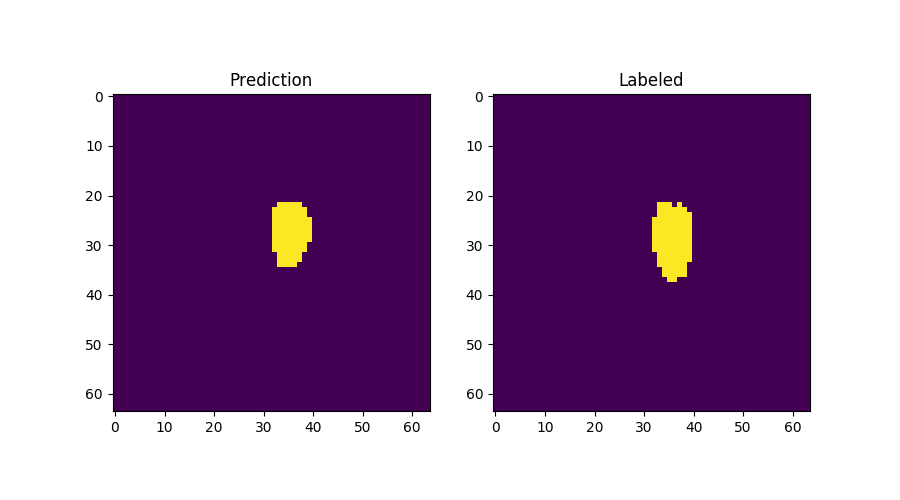

In [44]:
plt.figure(figsize=(9, 5))
plt.subplot(121)
plt.title("Prediction")
plt.imshow(y_pred_test)
plt.subplot(122)
plt.title("Labeled")
plt.imshow(Y_test[0, :, :, 0]);

<IPython.core.display.Javascript object>


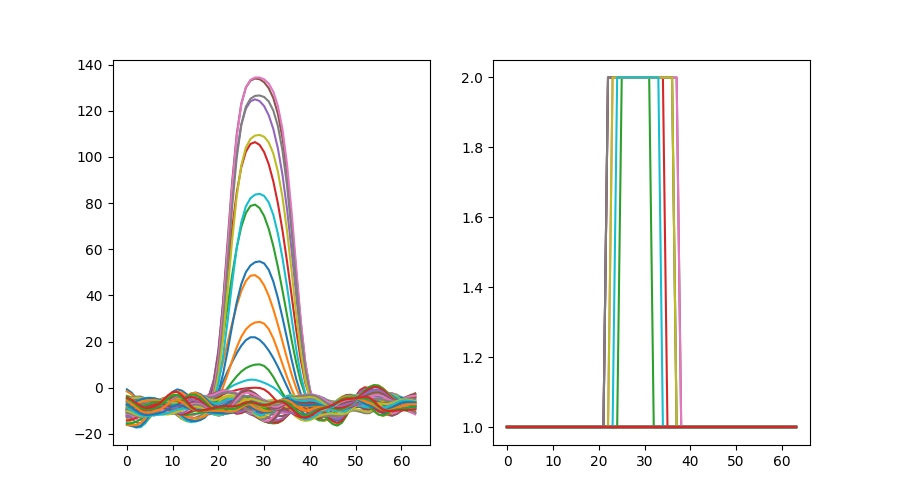

<IPython.core.display.Javascript object>


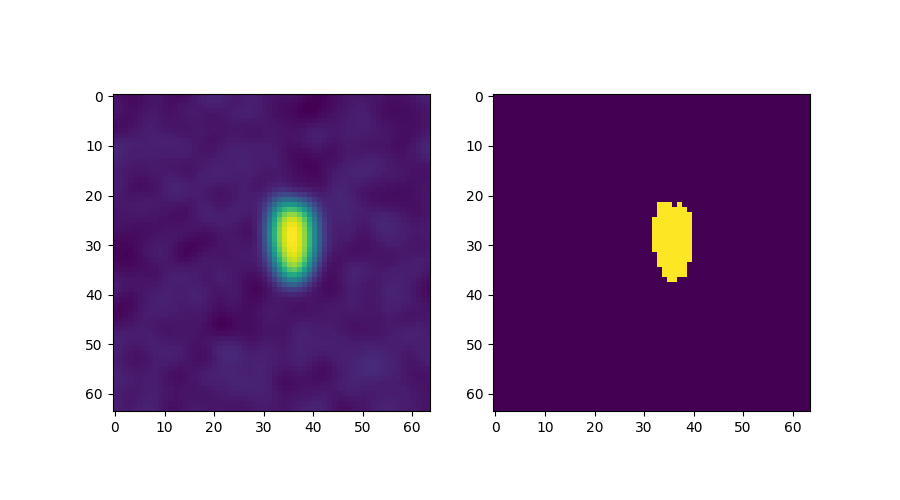

In [45]:
%matplotlib notebook

plt.figure(figsize=(9, 5))
plt.subplot(121)
plt.plot(X_test[0, :, :, 0])
plt.subplot(122)
plt.plot(Y_test[0, :, :, 0]);

plt.figure(figsize=(9, 5))
plt.subplot(121)
plt.imshow(X_test[0, :, :, 0])
plt.subplot(122)
plt.imshow(Y_test[0, :, :, 0]);

              precision    recall  f1-score   support

           1       0.99      1.00      0.99     35920
           2       0.82      0.55      0.66       944

    accuracy                           0.99     36864
   macro avg       0.90      0.77      0.83     36864
weighted avg       0.98      0.99      0.98     36864



<IPython.core.display.Javascript object>


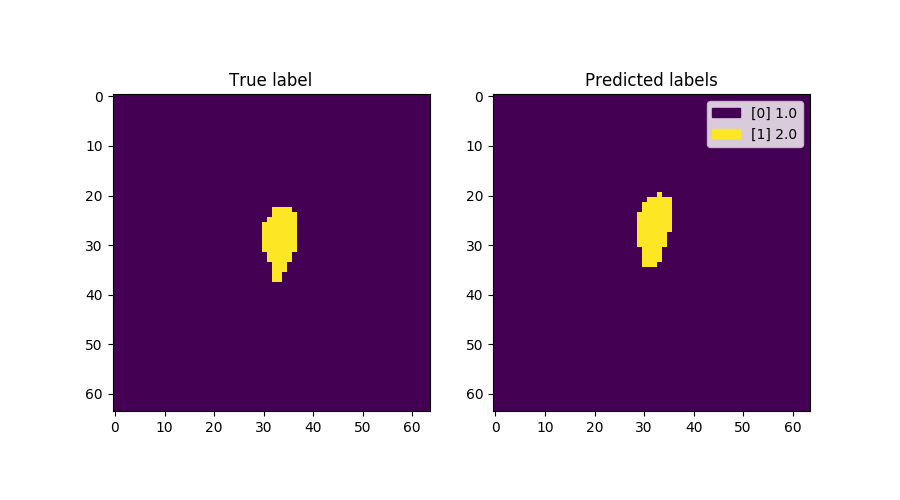

In [48]:
model.predict(X_test, Y_test)

# Setup a ensemble SVM classification

In [6]:
# from sklearn import model_selection
# from sklearn.ensemble import GradientBoostingClassifier

# train = mypackage.StackTransform(X_train, Y_train)
# test = mypackage.StackTransform(X_test)

# # svc_classifier = svm.SVC(C=1, kernel='rbf', decision_function_shape='ovr')
# # svc_classifier.fit(train.X_stack(), train.Y_stack().ravel())
# # Y_hat = svc_classifier.predict(test.X_stack())
# # Y_hat = test.Unstack(Y_hat, k=1)

# X = train.X_stack()
# Y = train.Y_stack().ravel()
# seed = 7
# num_trees = 100
# kfold = model_selection.KFold(n_splits=10, random_state=seed)
# model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
# results = model_selection.cross_val_score(model, X, Y, cv=kfold)
# print(results.mean())

# model.fit(train.X_stack(), train.Y_stack().ravel())

# # Y_hat = model.predict(test.X_stack())
# # Y_hat = test.Unstack(Y_hat, k=1)

# import matplotlib.pyplot as plt
# plt.figure(figsize=(15, 15))
# plt.subplot(1, 2, 1)
# plt.title("True Classes")
# i = 1
# plt.imshow(np.squeeze(Y_test[i]))
# plt.axis('off')
# plt.subplot(1, 2, 2)
# plt.title("Logistic Regression Classification")
# plt.imshow(np.squeeze(Y_hat[i]))
# plt.axis('off');

/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



0.9949539892341169


# Testing SVM

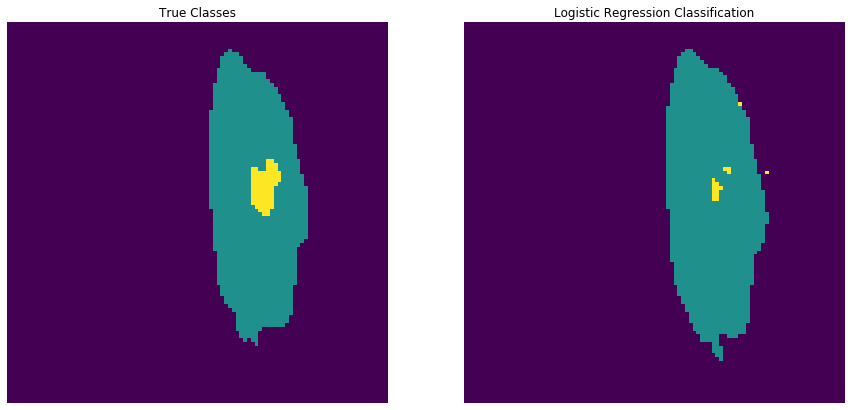

In [4]:
from sklearn import svm

train = mypackage.StackTransform(X_train, Y_train)
test = mypackage.StackTransform(X_test)

svc_classifier = svm.SVC(C=1, kernel='rbf', decision_function_shape='ovr')
svc_classifier.fit(train.X_stack(), train.Y_stack().ravel())
Y_hat = svc_classifier.predict(test.X_stack())
Y_hat = test.Unstack(Y_hat, k=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title("True Classes")
plt.imshow(np.squeeze(Y_test[0]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Logistic Regression Classification")
plt.imshow(np.squeeze(Y_hat[0]))
plt.axis('off');

# Testing Logistic Regression

0.49021545217510637
For all test data the weighted accuracy_score with weights=[ 0  1 20] gives the score of: 0.4902
F1_score = 0.9794
Precision_score = 0.9794
Recall_score = 0.9794


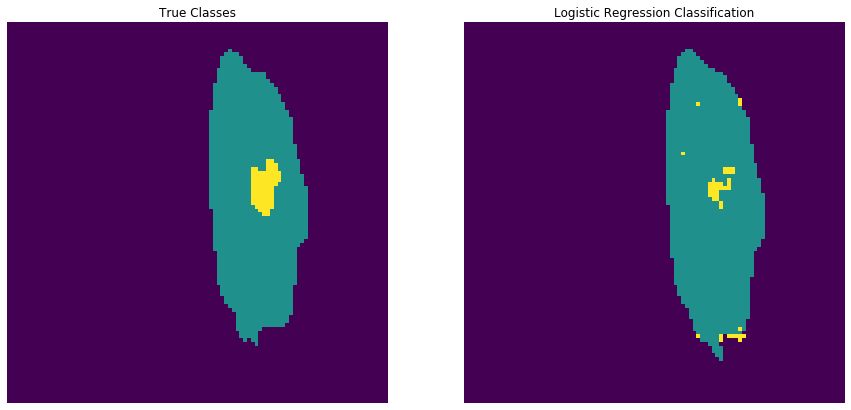

Weighted accuracy_score with weights=[ 0  1 20] gives the score of: 0.6511


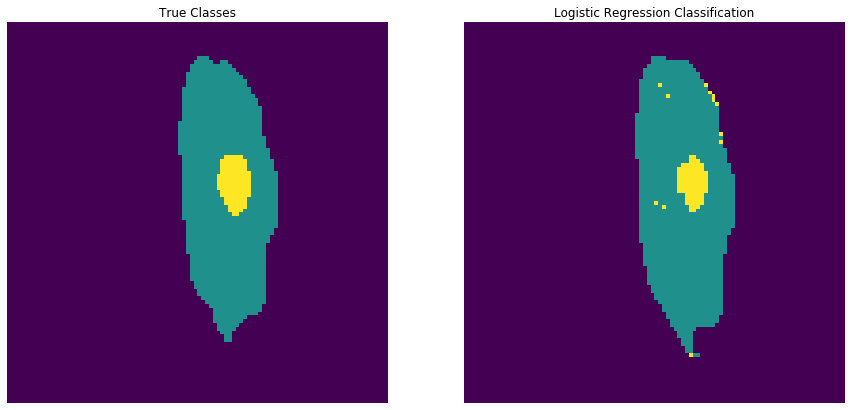

Weighted accuracy_score with weights=[ 0  1 20] gives the score of: 0.8659


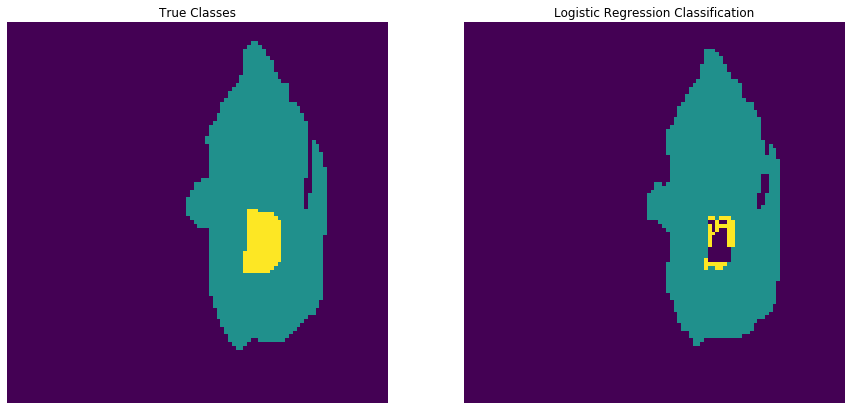

Weighted accuracy_score with weights=[ 0  1 20] gives the score of: 0.5332


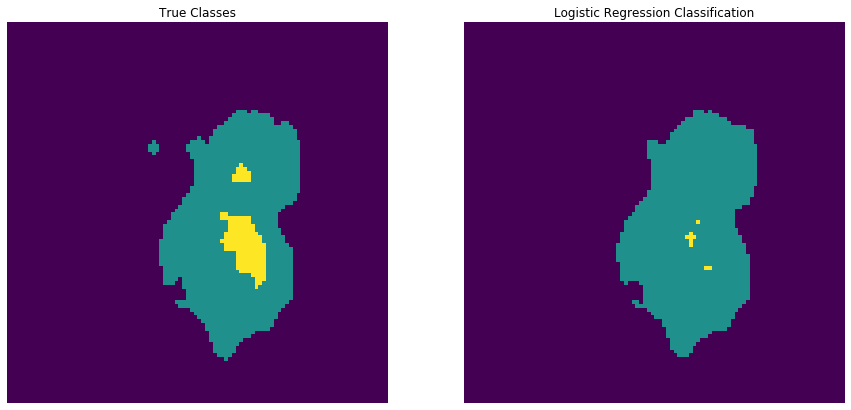

Weighted accuracy_score with weights=[ 0  1 20] gives the score of: 0.3502


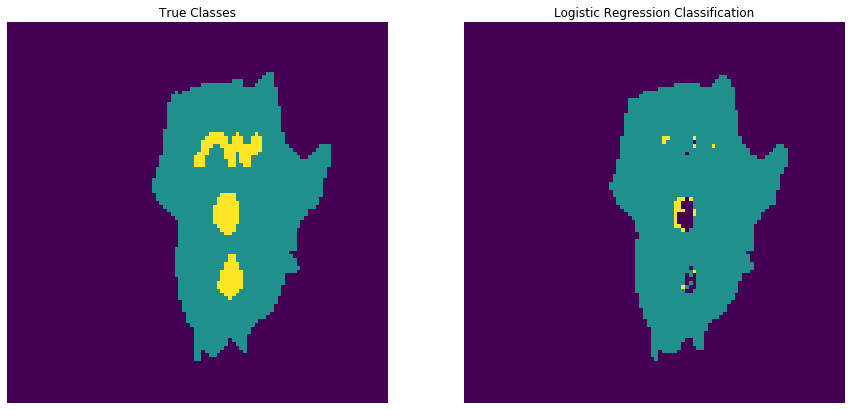

Weighted accuracy_score with weights=[ 0  1 20] gives the score of: 0.3978


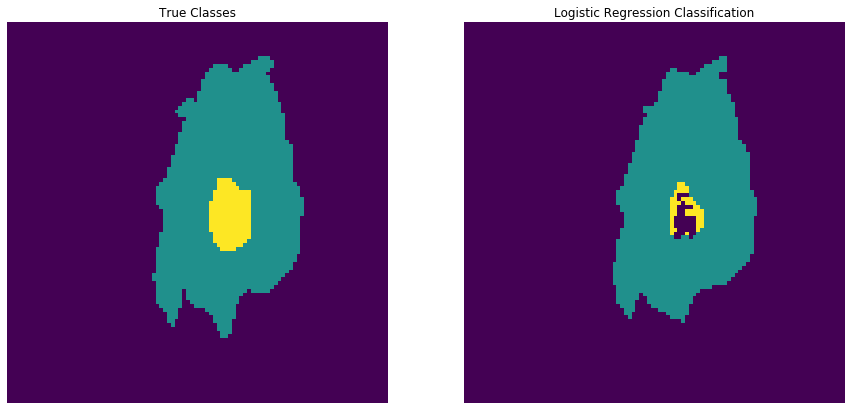

Weighted accuracy_score with weights=[ 0  1 20] gives the score of: 0.5119


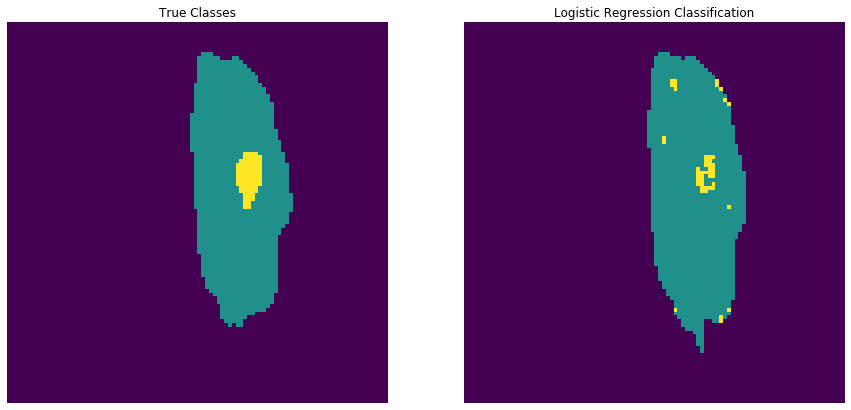

Weighted accuracy_score with weights=[ 0  1 20] gives the score of: 0.6733


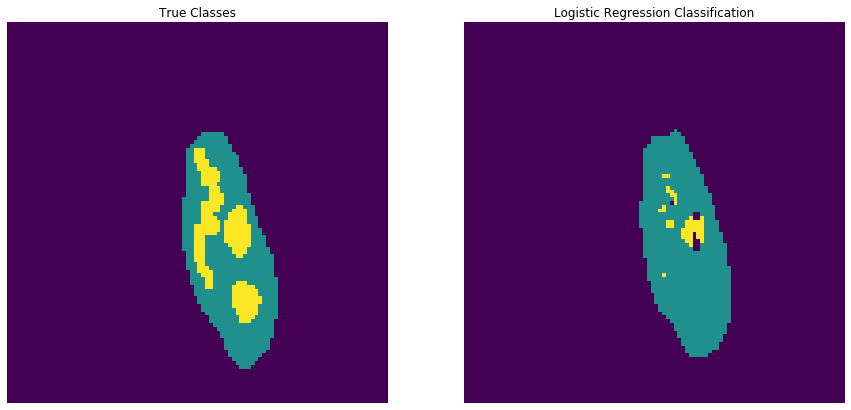

Weighted accuracy_score with weights=[ 0  1 20] gives the score of: 0.2651


In [5]:
log_reg = mypackage.logistic_regression(X_train, Y_train, X_test, Y_test, C=1e5)

In [8]:
from sklearn import preprocessing

X, Y, info, X_rest = mypackage.Dataset.load("data/tomra", only_with_contaminant=True, load_rest=True)
X_rest, X = mypackage.Dataset.scale(X_rest, X, scale='RemoveTrend')
trans = mypackage.StackTransform(X, Y)
trans_rest = mypackage.StackTransform(X_rest)

# Scaling
scaler = preprocessing.StandardScaler()
scaler.fit(trans.X_stack())
X_scaled = scaler.transform(trans.X_stack())
X_scaled = trans.Unstack(X_scaled)

log_reg = mypackage.logistic_regression(X_scaled, Y, X_rest, None, C=1e5, plot=False, metrics=False, max_iter=10000)

In [50]:
# Plot the classification of the rest
# file_list = ['20200213_115743_FM_fillet_repeat_sample_B_26', '20200213_114942_skinside_sample_B_22', '20200213_120225_FM_fillet_repeat_sample_B_35', '20200213_121453_new_FM_fillet_sample_C_32', '20200213_121213_new_FM_fillet_sample_C_27', '20200213_114630_fillet_sample48', '20200213_115538_FM_fillet_repeat_sample_B_21', '20200213_113731_fillet_sample29', '20200213_115916_FM_fillet_repeat_sample_B_29', '20200213_113311_fillet_sample20', '20200213_114007_fillet_sample34', '20200213_114322_fillet_sample40', '20200213_115706_FM_fillet_repeat_sample_B_25', '20200213_114523_fillet_sample45', '20200213_115030_skinside_sample_B_24', '20200213_114347_fillet_sample41', '20200213_115939_FM_fillet_repeat_sample_B_30', '20200213_120912_new_FM_fillet_sample_C_22', '20200213_113854_fillet_sample31', '20200213_114502_fillet_sample44', '20200213_121438_new_FM_fillet_sample_C_31', '20200213_113949_fillet_sample33', '20200213_120821_new_FM_fillet_sample_C_20', '20200213_120956_new_FM_fillet_sample_C_23', '20200213_121142_new_FM_fillet_sample_C_26', '20200213_113459_fillet_sample22', '20200213_114414_fillet_sample42', '20200213_113632_fillet_sample25', '20200213_121354_new_FM_fillet_sample_C_29', '20200213_114648_fillet_sample49', '20200213_115955_FM_fillet_repeat_sample_B_31', '20200213_121023_new_FM_fillet_sample_C_24', '20200213_115559_FM_fillet_repeat_sample_B_22', '20200213_114857_skinside_sample_B_20', '20200213_115118_skinside_sample_B_26', '20200213_120849_new_FM_fillet_sample_C_21', '20200213_113428_fillet_sample21', '20200213_115648_FM_fillet_repeat_sample_B_24', '20200213_113531_fillet_sample23', '20200213_114025_fillet_sample35', '20200213_115808_FM_fillet_repeat_sample_B_27', '20200213_113617_fillet_sample24', '20200213_114052_fillet_sample36', '20200213_115055_skinside_sample_B_25', '20200213_114552_fillet_sample46', '20200213_113705_fillet_sample27', '20200213_115449_FM_fillet_repeat_sample_B_20', '20200213_113719_fillet_sample28', '20200213_115625_FM_fillet_repeat_sample_B_23', '20200213_113826_fillet_sample30', '20200213_115201_skinside_sample_B_27', '20200213_121045_new_FM_fillet_sample_C_25', '20200213_120111_FM_fillet_repeat_sample_B_33', '20200213_114807_fillet_sample50', '20200213_113646_fillet_sample26', '20200213_114922_skinside_sample_B_21', '20200213_121417_new_FM_fillet_sample_C_30', '20200213_113925_fillet_sample32', '20200213_121237_new_FM_fillet_sample_C_28', '20200213_114437_fillet_sample43', '20200213_120158_FM_fillet_repeat_sample_B_34']
# for i, file_name in enumerate(file_list):
#     rest = mypackage.StackTransform(X_rest[i:i+1])
#     X_stacked = rest.X_stack()
#     Y_hat_stacked = log_reg.predict(X_stacked)
#     Y_hat = rest.Unstack(Y_hat_stacked, k=1)

#     plt.figure(figsize=(10, 5))
#     plt.title(file_name)
#     plt.imshow(np.squeeze(Y_hat))
#     plt.imsave(file_name+'.png', np.squeeze(Y_hat))
#     plt.show()

# Test Partial Least Squares - Discriminant Analysis (PLS-DA)

# Evaluate the results
### With precision / recall or something